In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
# other dependencies
#!pip install timm ipywidgets

In [4]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [7]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [8]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [9]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [10]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [11]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [12]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [13]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [14]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [15]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [16]:
len(df)

6008

In [17]:
USE_SHORT_AUDIO = True

In [18]:
#Test should happen on Cup and Tanzania
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [19]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [20]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_temp = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)

### Verifying that the temp data does not have any test leakage

In [21]:
#np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()
#df_temp([df_temp['country'] == 'Tanzania' and df_temp['location_type'] == 'cup'])

/tmp/ipykernel_2567634/2543128270.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()


index              0.0
id                 0.0
length             0.0
name               0.0
sample_rate        0.0
record_datetime    0.0
sound_type         0.0
species            0.0
gender             0.0
fed                0.0
plurality          0.0
age                0.0
method             0.0
mic_type           0.0
device_type        0.0
country            0.0
district           0.0
province           0.0
place              0.0
location_type      0.0
specie_ind         0.0
dtype: float64

In [22]:
df_temp.reset_index(inplace = True)
df_temp.drop('index',axis = 1,inplace = True)
df_temp.drop('level_0',axis = 1,inplace = True)

In [23]:
df_temp

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3455,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3456,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3457,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [24]:
print("len of df_temp = " + str(len(df_temp)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_temp)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training

In [25]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


In [26]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [27]:
len(df_test)

510

Add some TZ_cup sampled to the Training data

In [28]:
temp_train_frame = [df_temp , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


### Finally a train-val split

In [29]:
from sklearn.model_selection import train_test_split

#df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
df_train,df_val  = train_test_split(df_temp_train, test_size=0.2 , random_state= 42)

In [30]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 4398
length of val = 1100


In [31]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [32]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 104000
length of test offset = 23294
length of val offset = 24518


In [33]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [34]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [35]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [36]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [37]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.3844931  0.80723406 4.37048243 0.81245557 3.46078333 5.12214342
 3.94118539 9.71055089 0.34967033]


In [38]:
len(df_val_offset)

24518

In [39]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [40]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [41]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    #print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [42]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [43]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [44]:
def concat_df(df_offset, indices):
    list_df_ind = []
    #print("len of indices = " + str(len(indices)))
    for ind in indices :
        df_name = "df_"+ str(ind)
        df_name = df_offset[df_offset['specie_ind'] == ind]
        list_df_ind.append(df_name)
    df_offset_trimmed = pd.concat(list_df_ind)
    return(df_offset_trimmed)

In [45]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [46]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [47]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [48]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,222214,0,10.24,8
1,1,222214,2561,10.24,8
2,2,222214,5121,10.24,8
3,3,222214,7681,10.24,8
4,4,222214,10241,10.24,8


In [49]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [50]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_train_acc = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_acc.append(train_acc)
        val_loss, val_acc , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_acc))
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)
        
        acc_metric = val_acc
        best_acc_metric = best_val_acc
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [51]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_zero(waveform)
        else:
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [52]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [53]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [54]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [55]:
df_train_offset

,index,id,offset,length,specie_ind
0,0,222214,0,10.24000,8
1,1,222214,2561,10.24000,8
2,2,222214,5121,10.24000,8
3,3,222214,7681,10.24000,8
4,4,222214,10241,10.24000,8
...,...,...,...,...,...
103995,103995,1130,43521,9.20562,8
103996,103996,1130,46081,9.20562,8
103997,103997,1130,48641,9.20562,8
103998,103998,1130,51201,9.20562,8


In [56]:
train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [57]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 104000
Length of train loader = 813


In [58]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [59]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [60]:
len(df_train_offset)

104000

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0799 seconds
Training on cuda:0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 0batch = 0 of 813duraation = 0.08307783206303915
epoch = 0batch = 200 of 813duraation = 4.4257147471110025
epoch = 0batch = 400 of 813duraation = 8.746666638056437
epoch = 0batch = 600 of 813duraation = 13.162855140368144
epoch = 0batch = 800 of 813duraation = 17.544393662611643
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_16_11_10_25.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.66      0.41      0.50      9018
culex pipiens complex       0.52      0.32      0.40      4157
           ae aegypti       0.06      0.49      0.11       429
       an funestus ss       0.41      0.37      0.39      3422
         an squamosus       0.16      0.15      0.15      1327
          an coustani       0.25      0.53      0.34       657
         ma uniformis       0.14      0.09      0.11       975
         ma africanus       0.08      0.36      0.13       423
               others       0.

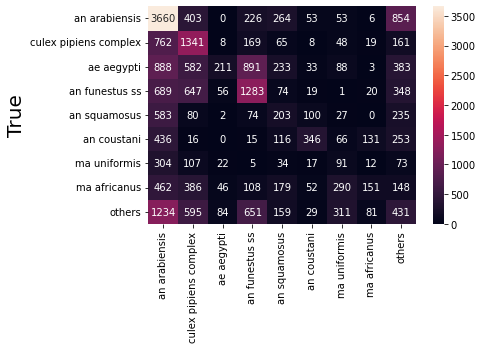

Epoch: 0, Train Loss: 1.67966180, Train Acc: 0.35538462, Val Loss: 0.00728644, Val Acc: 0.50681132, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 1batch = 0 of 813duraation = 0.08450701236724853
epoch = 1batch = 200 of 813duraation = 4.460748664538065
epoch = 1batch = 400 of 813duraation = 8.81352694829305
epoch = 1batch = 600 of 813duraation = 13.339395809173585
epoch = 1batch = 800 of 813duraation = 17.761275176207224
Saving model to: ../outputs/models/pytorch/model_e1_2022_09_16_11_38_41.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.68      0.36      0.48      9018
culex pipiens complex       0.36      0.59      0.45      4157
           ae aegypti       0.11      0.33      0.16       429
       an funestus ss       0.49      0.51      0.50      3422
         an squamosus       0.16      0.38      0.22      1327
          an coustani       0.24      0.45      0.31       657
         ma uniformis       0.19      0.19      0.19       975
         ma africanus       0.11      0.15      0.13       423
               others       0.17

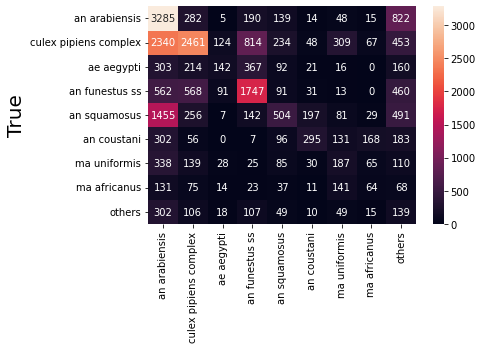

Epoch: 1, Train Loss: 1.00880687, Train Acc: 0.60284615, Val Loss: 0.00623479, Val Acc: 0.58271474, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 2batch = 0 of 813duraation = 0.08166016737620035
epoch = 2batch = 200 of 813duraation = 4.40964154402415
epoch = 2batch = 400 of 813duraation = 8.725901925563813
epoch = 2batch = 600 of 813duraation = 13.426131089528402
epoch = 2batch = 800 of 813duraation = 17.966614508628844
Saving model to: ../outputs/models/pytorch/model_e2_2022_09_16_12_06_24.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.68      0.41      0.51      9018
culex pipiens complex       0.52      0.41      0.46      4157
           ae aegypti       0.10      0.37      0.16       429
       an funestus ss       0.42      0.73      0.53      3422
         an squamosus       0.18      0.34      0.23      1327
          an coustani       0.19      0.46      0.27       657
         ma uniformis       0.25      0.19      0.21       975
         ma africanus       0.15      0.26      0.19       423
               others       0.28

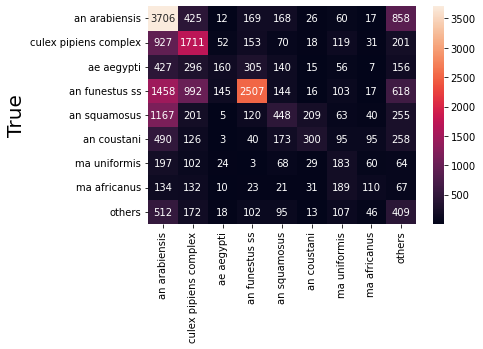

Epoch: 2, Train Loss: 0.73079520, Train Acc: 0.68739423, Val Loss: 0.00618067, Val Acc: 0.60502488, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 3batch = 0 of 813duraation = 0.08290072679519653
epoch = 3batch = 200 of 813duraation = 4.3870909492174786
epoch = 3batch = 400 of 813duraation = 8.706671019395193
epoch = 3batch = 600 of 813duraation = 13.736822803815206
epoch = 3batch = 800 of 813duraation = 18.363744382063548
Saving model to: ../outputs/models/pytorch/model_e3_2022_09_16_12_34_32.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.65      0.47      0.54      9018
culex pipiens complex       0.47      0.53      0.49      4157
           ae aegypti       0.22      0.24      0.23       429
       an funestus ss       0.52      0.63      0.57      3422
         an squamosus       0.18      0.47      0.26      1327
          an coustani       0.28      0.47      0.35       657
         ma uniformis       0.20      0.19      0.19       975
         ma africanus       0.14      0.10      0.11       423
               others       0.

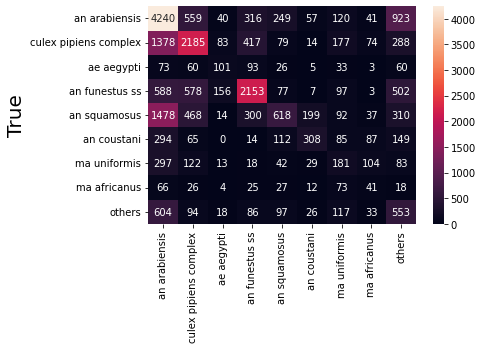

Epoch: 3, Train Loss: 0.56163895, Train Acc: 0.74723077, Val Loss: 0.00592394, Val Acc: 0.63842891, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 4batch = 0 of 813duraation = 0.08334529002507528
epoch = 4batch = 200 of 813duraation = 4.434597925345103
epoch = 4batch = 400 of 813duraation = 8.775656529267629
epoch = 4batch = 600 of 813duraation = 13.452558743953706
epoch = 4batch = 800 of 813duraation = 18.30307271083196
Epoch: 4, Train Loss: 0.45601407, Train Acc: 0.79056731, Val Loss: 0.00623747, Val Acc: 0.63671588, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 5batch = 0 of 813duraation = 0.08697641293207804
epoch = 5batch = 200 of 813duraation = 4.433712458610534
epoch = 5batch = 400 of 813duraation = 8.783118077119191
epoch = 5batch = 600 of 813duraation = 13.10763912598292
epoch = 5batch = 800 of 813duraation = 17.993546052773794
Saving model to: ../outputs/models/pytorch/model_e5_2022_09_16_13_25_01.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.65      0.59      0.62      9018
culex pipiens complex       0.51      0.52      0.51      4157
           ae aegypti       0.18      0.24      0.20       429
       an funestus ss       0.45      0.70      0.55      3422
         an squamosus       0.26      0.29      0.28      1327
          an coustani       0.21      0.35      0.27       657
         ma uniformis       0.29      0.22      0.25       975
         ma africanus       0.14      0.13      0.14       423
               others       0.38

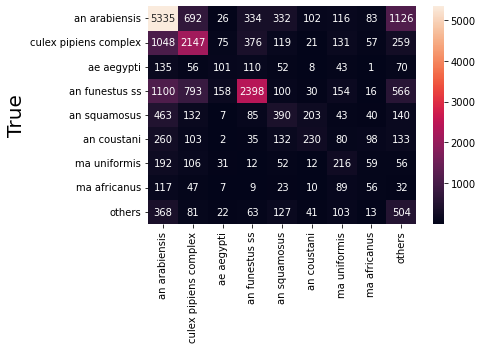

Epoch: 5, Train Loss: 0.37567599, Train Acc: 0.82680769, Val Loss: 0.00587667, Val Acc: 0.67945999, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 6batch = 0 of 813duraation = 0.09112623532613119
epoch = 6batch = 200 of 813duraation = 4.564065762360891
epoch = 6batch = 400 of 813duraation = 8.902851887543996
epoch = 6batch = 600 of 813duraation = 13.765605823198955
epoch = 6batch = 800 of 813duraation = 18.240683364868165
Epoch: 6, Train Loss: 0.31570673, Train Acc: 0.85198077, Val Loss: 0.00676423, Val Acc: 0.64332327, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 7batch = 0 of 813duraation = 0.08176385958989461
epoch = 7batch = 200 of 813duraation = 4.440333012739817
epoch = 7batch = 400 of 813duraation = 8.770037472248077
epoch = 7batch = 600 of 813duraation = 13.12424091498057
epoch = 7batch = 800 of 813duraation = 17.897485780715943
Epoch: 7, Train Loss: 0.28000978, Train Acc: 0.86925962, Val Loss: 0.00708745, Val Acc: 0.62847704, overrun_counter 2


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 8batch = 0 of 813duraation = 0.09919006029764811
epoch = 8batch = 200 of 813duraation = 4.701200501124064
epoch = 8batch = 400 of 813duraation = 9.067510024706523
epoch = 8batch = 600 of 813duraation = 13.434464263916016
epoch = 8batch = 800 of 813duraation = 18.79464836915334
Epoch: 8, Train Loss: 0.23753873, Train Acc: 0.88820192, Val Loss: 0.00670827, Val Acc: 0.66930418, overrun_counter 3


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 9batch = 0 of 813duraation = 0.09368457396825154
epoch = 9batch = 200 of 813duraation = 4.520422033468882
epoch = 9batch = 400 of 813duraation = 8.87497018178304
epoch = 9batch = 600 of 813duraation = 13.25016991297404
epoch = 9batch = 800 of 813duraation = 18.219204235076905
Epoch: 9, Train Loss: 0.21361517, Train Acc: 0.89977885, Val Loss: 0.00675847, Val Acc: 0.66665307, overrun_counter 4


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 10batch = 0 of 813duraation = 0.09544978539148967
epoch = 10batch = 200 of 813duraation = 4.713332982858022
epoch = 10batch = 400 of 813duraation = 9.049021514256795
epoch = 10batch = 600 of 813duraation = 13.42173742055893
epoch = 10batch = 800 of 813duraation = 17.773562041918435
Epoch: 10, Train Loss: 0.17562636, Train Acc: 0.91824038, Val Loss: 0.00754376, Val Acc: 0.63708296, overrun_counter 5


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 11batch = 0 of 813duraation = 0.07755738099416097
epoch = 11batch = 200 of 813duraation = 4.522678709030151
epoch = 11batch = 400 of 813duraation = 8.883509540557862
epoch = 11batch = 600 of 813duraation = 13.229796083768209
epoch = 11batch = 800 of 813duraation = 17.911142468452454
Epoch: 11, Train Loss: 0.18296648, Train Acc: 0.91803846, Val Loss: 0.00713898, Val Acc: 0.67476956, overrun_counter 6


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 12batch = 0 of 813duraation = 0.1032729427019755
epoch = 12batch = 200 of 813duraation = 4.479170378049215
epoch = 12batch = 400 of 813duraation = 8.814792696634928
epoch = 12batch = 600 of 813duraation = 13.166431836287181
epoch = 12batch = 800 of 813duraation = 17.54856602350871
Epoch: 12, Train Loss: 0.15903402, Train Acc: 0.92827885, Val Loss: 0.00741418, Val Acc: 0.67321968, overrun_counter 7


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 13batch = 0 of 813duraation = 0.08799787362416585
epoch = 13batch = 200 of 813duraation = 4.461792127291361
epoch = 13batch = 400 of 813duraation = 8.804301695028942
epoch = 13batch = 600 of 813duraation = 13.157136563460032
epoch = 13batch = 800 of 813duraation = 17.667774522304533
Epoch: 13, Train Loss: 0.15598856, Train Acc: 0.93025000, Val Loss: 0.00733093, Val Acc: 0.67497349, overrun_counter 8


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 14batch = 0 of 813duraation = 0.09184041023254394
epoch = 14batch = 200 of 813duraation = 4.57377415895462
epoch = 14batch = 400 of 813duraation = 8.95622886021932
epoch = 14batch = 600 of 813duraation = 13.303122746944428
epoch = 14batch = 800 of 813duraation = 17.864985112349192
Epoch: 14, Train Loss: 0.14139923, Train Acc: 0.93625000, Val Loss: 0.00687740, Val Acc: 0.67933763, overrun_counter 9


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 15batch = 0 of 813duraation = 0.11512943108876546
epoch = 15batch = 200 of 813duraation = 4.6705607612927755
epoch = 15batch = 400 of 813duraation = 9.03215070962906
epoch = 15batch = 600 of 813duraation = 13.39346098502477
epoch = 15batch = 800 of 813duraation = 17.799054777622224
Saving model to: ../outputs/models/pytorch/model_e15_2022_09_16_17_13_07.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.68      0.64      9018
culex pipiens complex       0.47      0.48      0.47      4157
           ae aegypti       0.19      0.38      0.25       429
       an funestus ss       0.54      0.54      0.54      3422
         an squamosus       0.27      0.20      0.23      1327
          an coustani       0.25      0.28      0.26       657
         ma uniformis       0.32      0.36      0.34       975
         ma africanus       0.29      0.20      0.24       423
               others     

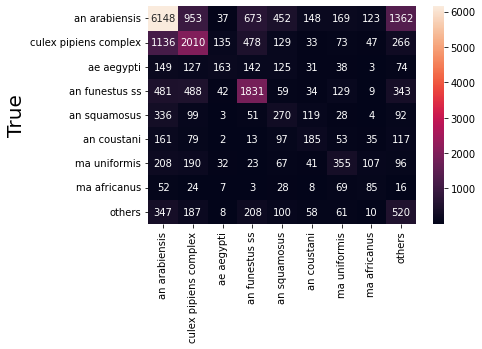

Epoch: 15, Train Loss: 0.12393575, Train Acc: 0.94363462, Val Loss: 0.00772045, Val Acc: 0.68039807, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 16batch = 0 of 813duraation = 0.10095184246699015
epoch = 16batch = 200 of 813duraation = 4.606605776151022
epoch = 16batch = 400 of 813duraation = 8.968911345799764
epoch = 16batch = 600 of 813duraation = 13.549884601434071
epoch = 16batch = 800 of 813duraation = 17.957572245597838
Epoch: 16, Train Loss: 0.12777216, Train Acc: 0.94319231, Val Loss: 0.00769929, Val Acc: 0.66151399, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 17batch = 0 of 813duraation = 0.08300752242406209
epoch = 17batch = 200 of 813duraation = 4.467212438583374
epoch = 17batch = 400 of 813duraation = 8.807311566670736
epoch = 17batch = 600 of 813duraation = 13.152194086710612
epoch = 17batch = 800 of 813duraation = 17.919466960430146
Saving model to: ../outputs/models/pytorch/model_e17_2022_09_16_18_04_06.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.69      0.65      9018
culex pipiens complex       0.49      0.47      0.48      4157
           ae aegypti       0.17      0.15      0.16       429
       an funestus ss       0.51      0.61      0.55      3422
         an squamosus       0.29      0.26      0.27      1327
          an coustani       0.30      0.41      0.34       657
         ma uniformis       0.30      0.23      0.26       975
         ma africanus       0.23      0.14      0.17       423
               others    

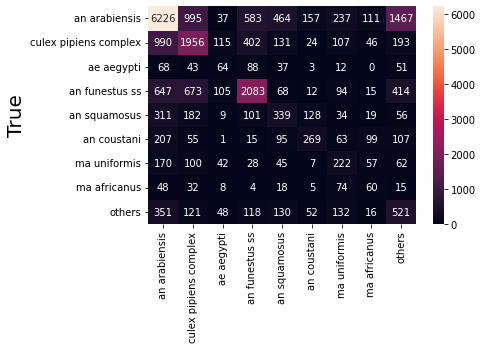

Epoch: 17, Train Loss: 0.12284178, Train Acc: 0.94591346, Val Loss: 0.00805245, Val Acc: 0.68692389, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 18batch = 0 of 813duraation = 0.09179346164067587
epoch = 18batch = 200 of 813duraation = 4.538790428638459
epoch = 18batch = 400 of 813duraation = 8.887143421173096
epoch = 18batch = 600 of 813duraation = 13.544594832261403
epoch = 18batch = 800 of 813duraation = 18.03214317560196
Epoch: 18, Train Loss: 0.11819637, Train Acc: 0.94796154, Val Loss: 0.00770178, Val Acc: 0.67595236, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 19batch = 0 of 813duraation = 0.08268702030181885
epoch = 19batch = 200 of 813duraation = 4.45775983730952
epoch = 19batch = 400 of 813duraation = 8.826015730698904
epoch = 19batch = 600 of 813duraation = 13.153679756323497
epoch = 19batch = 800 of 813duraation = 17.7044566988945
Epoch: 19, Train Loss: 0.11245373, Train Acc: 0.95157692, Val Loss: 0.00783138, Val Acc: 0.67901134, overrun_counter 2


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 20batch = 0 of 813duraation = 0.10217639605204264
epoch = 20batch = 200 of 813duraation = 4.4968860705693565
epoch = 20batch = 400 of 813duraation = 8.827249864737192
epoch = 20batch = 600 of 813duraation = 13.164359827836355
epoch = 20batch = 800 of 813duraation = 17.628778290748595
Saving model to: ../outputs/models/pytorch/model_e20_2022_09_16_19_16_04.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.68      0.64      9018
culex pipiens complex       0.53      0.46      0.50      4157
           ae aegypti       0.13      0.14      0.13       429
       an funestus ss       0.44      0.63      0.52      3422
         an squamosus       0.32      0.24      0.27      1327
          an coustani       0.26      0.39      0.31       657
         ma uniformis       0.36      0.25      0.30       975
         ma africanus       0.31      0.12      0.18       423
               others   

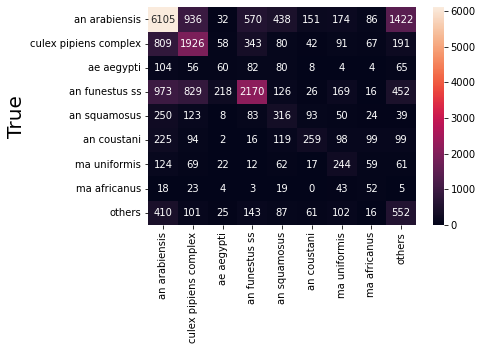

Epoch: 20, Train Loss: 0.10348655, Train Acc: 0.95531731, Val Loss: 0.00792821, Val Acc: 0.69039073, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 21batch = 0 of 813duraation = 0.09933974345525105
epoch = 21batch = 200 of 813duraation = 4.478627661863963
epoch = 21batch = 400 of 813duraation = 8.782745532194774
epoch = 21batch = 600 of 813duraation = 13.333134984970092
epoch = 21batch = 800 of 813duraation = 17.80464379787445
Epoch: 21, Train Loss: 0.10388138, Train Acc: 0.95449038, Val Loss: 0.00852714, Val Acc: 0.68292683, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 22batch = 0 of 813duraation = 0.07663970788319906
epoch = 22batch = 200 of 813duraation = 4.43842568397522
epoch = 22batch = 400 of 813duraation = 8.789867488543193
epoch = 22batch = 600 of 813duraation = 13.108817676703135
epoch = 22batch = 800 of 813duraation = 17.49845750729243
Saving model to: ../outputs/models/pytorch/model_e22_2022_09_16_20_05_15.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.66      0.64      9018
culex pipiens complex       0.48      0.52      0.50      4157
           ae aegypti       0.22      0.16      0.19       429
       an funestus ss       0.48      0.63      0.54      3422
         an squamosus       0.35      0.24      0.29      1327
          an coustani       0.23      0.31      0.26       657
         ma uniformis       0.35      0.24      0.28       975
         ma africanus       0.14      0.07      0.09       423
               others      

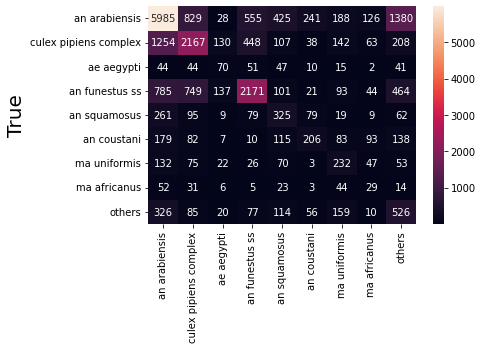

Epoch: 22, Train Loss: 0.08448437, Train Acc: 0.96250000, Val Loss: 0.00836123, Val Acc: 0.69365364, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 23batch = 0 of 813duraation = 0.13400731881459554
epoch = 23batch = 200 of 813duraation = 4.6242862383524574
epoch = 23batch = 400 of 813duraation = 8.98913330634435
epoch = 23batch = 600 of 813duraation = 13.319112968444824
epoch = 23batch = 800 of 813duraation = 17.858390255769095
Epoch: 23, Train Loss: 0.08994807, Train Acc: 0.96048077, Val Loss: 0.00847117, Val Acc: 0.67011991, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 24batch = 0 of 813duraation = 0.077453875541687
epoch = 24batch = 200 of 813duraation = 4.467010513941447
epoch = 24batch = 400 of 813duraation = 8.784821323553722
epoch = 24batch = 600 of 813duraation = 13.116069082419077
epoch = 24batch = 800 of 813duraation = 17.995702358086906
Epoch: 24, Train Loss: 0.09330574, Train Acc: 0.95966346, Val Loss: 0.00869114, Val Acc: 0.67248552, overrun_counter 2


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 25batch = 0 of 813duraation = 0.09038402239481608
epoch = 25batch = 200 of 813duraation = 4.583412114779154
epoch = 25batch = 400 of 813duraation = 8.98607297341029
epoch = 25batch = 600 of 813duraation = 13.333740750948587
epoch = 25batch = 800 of 813duraation = 17.754364279905953
Saving model to: ../outputs/models/pytorch/model_e25_2022_09_16_21_17_07.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.57      0.70      0.63      9018
culex pipiens complex       0.49      0.46      0.47      4157
           ae aegypti       0.23      0.38      0.28       429
       an funestus ss       0.51      0.55      0.53      3422
         an squamosus       0.30      0.24      0.27      1327
          an coustani       0.26      0.28      0.27       657
         ma uniformis       0.33      0.24      0.28       975
         ma africanus       0.17      0.08      0.10       423
               others     

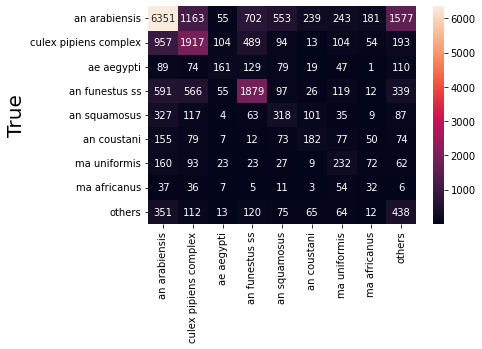

Epoch: 25, Train Loss: 0.09889744, Train Acc: 0.95765385, Val Loss: 0.00809209, Val Acc: 0.69434701, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 26batch = 0 of 813duraation = 0.16531071265538533
epoch = 26batch = 200 of 813duraation = 4.614486877123515
epoch = 26batch = 400 of 813duraation = 8.963925802707672
epoch = 26batch = 600 of 813duraation = 13.29410522778829
epoch = 26batch = 800 of 813duraation = 17.748240315914153
Epoch: 26, Train Loss: 0.08555304, Train Acc: 0.96406731, Val Loss: 0.00798206, Val Acc: 0.67778775, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 27batch = 0 of 813duraation = 0.1059750477472941
epoch = 27batch = 200 of 813duraation = 4.557302443186442
epoch = 27batch = 400 of 813duraation = 8.920934943358104
epoch = 27batch = 600 of 813duraation = 13.274275640646616
epoch = 27batch = 800 of 813duraation = 17.90424237648646
Saving model to: ../outputs/models/pytorch/model_e27_2022_09_16_22_07_29.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.58      0.70      0.64      9018
culex pipiens complex       0.45      0.51      0.48      4157
           ae aegypti       0.18      0.21      0.19       429
       an funestus ss       0.50      0.55      0.52      3422
         an squamosus       0.36      0.14      0.20      1327
          an coustani       0.27      0.30      0.28       657
         ma uniformis       0.38      0.24      0.29       975
         ma africanus       0.28      0.07      0.12       423
               others      

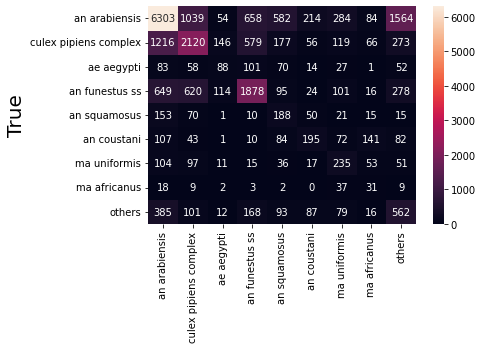

Epoch: 27, Train Loss: 0.08265844, Train Acc: 0.96417308, Val Loss: 0.00842883, Val Acc: 0.69862958, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 28batch = 0 of 813duraation = 0.0974172552426656
epoch = 28batch = 200 of 813duraation = 4.54510246515274
epoch = 28batch = 400 of 813duraation = 8.899115272363026
epoch = 28batch = 600 of 813duraation = 13.66049720843633
epoch = 28batch = 800 of 813duraation = 18.26098381280899
Epoch: 28, Train Loss: 0.08585297, Train Acc: 0.96261538, Val Loss: 0.00851752, Val Acc: 0.68957501, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 29batch = 0 of 813duraation = 0.08018972873687744
epoch = 29batch = 200 of 813duraation = 4.409648295243581
epoch = 29batch = 400 of 813duraation = 8.745829729239146
epoch = 29batch = 600 of 813duraation = 13.099190104007722
epoch = 29batch = 800 of 813duraation = 17.44819507598877
Epoch: 29, Train Loss: 0.06978859, Train Acc: 0.96921154, Val Loss: 0.00857847, Val Acc: 0.68986051, overrun_counter 2


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 30batch = 0 of 813duraation = 0.08126273949941
epoch = 30batch = 200 of 813duraation = 4.425340628623962
epoch = 30batch = 400 of 813duraation = 8.760821612675985
epoch = 30batch = 600 of 813duraation = 13.102867829799653
epoch = 30batch = 800 of 813duraation = 17.440683952967326
Epoch: 30, Train Loss: 0.07705226, Train Acc: 0.96793269, Val Loss: 0.00892416, Val Acc: 0.67175137, overrun_counter 3


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 31batch = 0 of 813duraation = 0.08187952836354574
epoch = 31batch = 200 of 813duraation = 4.416629596551259
epoch = 31batch = 400 of 813duraation = 8.760459105173746
epoch = 31batch = 600 of 813duraation = 13.05331867535909
epoch = 31batch = 800 of 813duraation = 17.36084707578023
Epoch: 31, Train Loss: 0.06894698, Train Acc: 0.97076923, Val Loss: 0.00877602, Val Acc: 0.66803981, overrun_counter 4


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 32batch = 0 of 813duraation = 0.081207013130188
epoch = 32batch = 200 of 813duraation = 4.394634131590525
epoch = 32batch = 400 of 813duraation = 8.693490143616994
epoch = 32batch = 600 of 813duraation = 13.064380240440368
epoch = 32batch = 800 of 813duraation = 17.47458606561025
Epoch: 32, Train Loss: 0.06306365, Train Acc: 0.97355769, Val Loss: 0.00898891, Val Acc: 0.67342361, overrun_counter 5


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 33batch = 0 of 813duraation = 0.08494540452957153
epoch = 33batch = 200 of 813duraation = 4.4233449578285216
epoch = 33batch = 400 of 813duraation = 8.758039291699728
epoch = 33batch = 600 of 813duraation = 13.058697752157848
epoch = 33batch = 800 of 813duraation = 17.468067546685536
Epoch: 33, Train Loss: 0.07973628, Train Acc: 0.96724038, Val Loss: 0.00864171, Val Acc: 0.68786198, overrun_counter 6


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 34batch = 0 of 813duraation = 0.09460494120915731
epoch = 34batch = 200 of 813duraation = 4.45270578066508
epoch = 34batch = 400 of 813duraation = 8.799037869771322
epoch = 34batch = 600 of 813duraation = 13.119750519593557
epoch = 34batch = 800 of 813duraation = 17.992594595750173
Epoch: 34, Train Loss: 0.06811147, Train Acc: 0.97014423, Val Loss: 0.00868504, Val Acc: 0.68508851, overrun_counter 7


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 35batch = 0 of 813duraation = 0.08777103424072266
epoch = 35batch = 200 of 813duraation = 4.517627263069153
epoch = 35batch = 400 of 813duraation = 8.850046428044637
epoch = 35batch = 600 of 813duraation = 13.17304875055949
epoch = 35batch = 800 of 813duraation = 17.555171291033428
Epoch: 35, Train Loss: 0.06606112, Train Acc: 0.97108654, Val Loss: 0.00895566, Val Acc: 0.67260788, overrun_counter 8


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 36batch = 0 of 813duraation = 0.08729420105616252
epoch = 36batch = 200 of 813duraation = 4.440912814935048
epoch = 36batch = 400 of 813duraation = 8.800153958797456
epoch = 36batch = 600 of 813duraation = 13.084105257193247
epoch = 36batch = 800 of 813duraation = 17.472601687908174
Saving model to: ../outputs/models/pytorch/model_e36_2022_09_17_01_28_12.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.68      0.64      9018
culex pipiens complex       0.50      0.46      0.48      4157
           ae aegypti       0.27      0.24      0.26       429
       an funestus ss       0.47      0.62      0.53      3422
         an squamosus       0.32      0.21      0.25      1327
          an coustani       0.20      0.35      0.26       657
         ma uniformis       0.36      0.19      0.25       975
         ma africanus       0.13      0.09      0.11       423
               others    

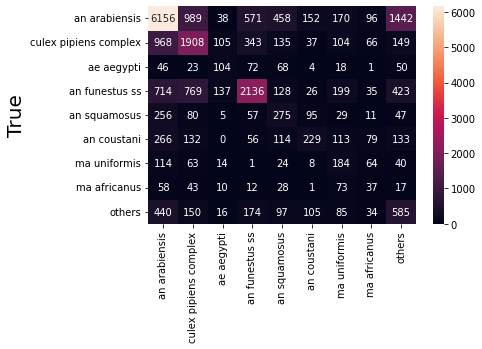

Epoch: 36, Train Loss: 0.06470229, Train Acc: 0.97299038, Val Loss: 0.00886004, Val Acc: 0.69911901, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 37batch = 0 of 813duraation = 0.0809309442838033
epoch = 37batch = 200 of 813duraation = 4.426608860492706
epoch = 37batch = 400 of 813duraation = 8.74707457224528
epoch = 37batch = 600 of 813duraation = 13.107002790768941
epoch = 37batch = 800 of 813duraation = 17.456796717643737
Epoch: 37, Train Loss: 0.05868093, Train Acc: 0.97403846, Val Loss: 0.00893217, Val Acc: 0.68447671, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 38batch = 0 of 813duraation = 0.08662839730580647
epoch = 38batch = 200 of 813duraation = 4.4174214442571005
epoch = 38batch = 400 of 813duraation = 8.719935131072997
epoch = 38batch = 600 of 813duraation = 13.053335805734
epoch = 38batch = 800 of 813duraation = 17.452268354098003
Epoch: 38, Train Loss: 0.05805887, Train Acc: 0.97497115, Val Loss: 0.00871212, Val Acc: 0.68349784, overrun_counter 2


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 39batch = 0 of 813duraation = 0.07930131753285725
epoch = 39batch = 200 of 813duraation = 4.4171661019325255
epoch = 39batch = 400 of 813duraation = 8.740867765744527
epoch = 39batch = 600 of 813duraation = 13.06070745786031
epoch = 39batch = 800 of 813duraation = 17.473909731705984
Epoch: 39, Train Loss: 0.07234202, Train Acc: 0.97054808, Val Loss: 0.00877613, Val Acc: 0.68712782, overrun_counter 3


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 40batch = 0 of 813duraation = 0.08761886358261109
epoch = 40batch = 200 of 813duraation = 4.465081751346588
epoch = 40batch = 400 of 813duraation = 8.801757315794626
epoch = 40batch = 600 of 813duraation = 13.089018845558167
epoch = 40batch = 800 of 813duraation = 17.395533434549968
Epoch: 40, Train Loss: 0.05840447, Train Acc: 0.97538462, Val Loss: 0.00935187, Val Acc: 0.68415042, overrun_counter 4


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 41batch = 0 of 813duraation = 0.08839293718338012
epoch = 41batch = 200 of 813duraation = 4.417878524462382
epoch = 41batch = 400 of 813duraation = 8.772002295653026
epoch = 41batch = 600 of 813duraation = 13.118630838394164
epoch = 41batch = 800 of 813duraation = 17.457031297683717
Epoch: 41, Train Loss: 0.06129545, Train Acc: 0.97430769, Val Loss: 0.00906987, Val Acc: 0.67721674, overrun_counter 5


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 42batch = 0 of 813duraation = 0.08524638811747233
epoch = 42batch = 200 of 813duraation = 4.454620663324992
epoch = 42batch = 400 of 813duraation = 8.807367992401122
epoch = 42batch = 600 of 813duraation = 13.121289229393005
epoch = 42batch = 800 of 813duraation = 17.480307189623513
Epoch: 42, Train Loss: 0.05750800, Train Acc: 0.97591346, Val Loss: 0.00828965, Val Acc: 0.68382413, overrun_counter 6


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 43batch = 0 of 813duraation = 0.09146733283996582
epoch = 43batch = 200 of 813duraation = 4.454268825054169
epoch = 43batch = 400 of 813duraation = 8.806486105918884
epoch = 43batch = 600 of 813duraation = 13.117832068602244
epoch = 43batch = 800 of 813duraation = 17.49649770259857
Epoch: 43, Train Loss: 0.05588682, Train Acc: 0.97584615, Val Loss: 0.00914300, Val Acc: 0.68561873, overrun_counter 7


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 44batch = 0 of 813duraation = 0.0858318567276001
epoch = 44batch = 200 of 813duraation = 4.407488532861074
epoch = 44batch = 400 of 813duraation = 8.731231172879538
epoch = 44batch = 600 of 813duraation = 13.048190192381542
epoch = 44batch = 800 of 813duraation = 17.485679841041566
Saving model to: ../outputs/models/pytorch/model_e44_2022_09_17_04_24_30.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.65      0.63      9018
culex pipiens complex       0.43      0.57      0.49      4157
           ae aegypti       0.18      0.18      0.18       429
       an funestus ss       0.51      0.56      0.54      3422
         an squamosus       0.32      0.18      0.23      1327
          an coustani       0.31      0.22      0.26       657
         ma uniformis       0.37      0.24      0.29       975
         ma africanus       0.10      0.03      0.05       423
               others     

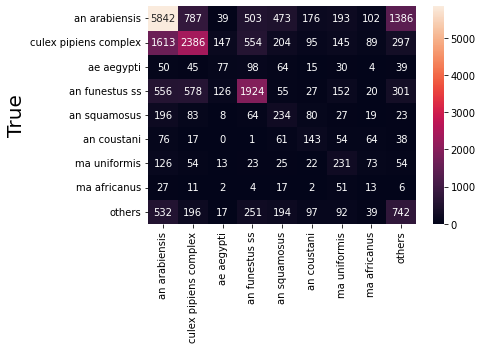

Epoch: 44, Train Loss: 0.05715518, Train Acc: 0.97653846, Val Loss: 0.00892113, Val Acc: 0.69928216, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 45batch = 0 of 813duraation = 0.09409565130869547
epoch = 45batch = 200 of 813duraation = 4.494963304201762
epoch = 45batch = 400 of 813duraation = 8.858873828252156
epoch = 45batch = 600 of 813duraation = 13.187702802817027
epoch = 45batch = 800 of 813duraation = 17.666783090432485
Epoch: 45, Train Loss: 0.05499736, Train Acc: 0.97583654, Val Loss: 0.00910296, Val Acc: 0.69296027, overrun_counter 1


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 46batch = 0 of 813duraation = 0.0868859608968099
epoch = 46batch = 200 of 813duraation = 4.4012389302253725


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 50batch = 200 of 813duraation = 4.4204744021097815
epoch = 50batch = 400 of 813duraation = 8.736594331264495
epoch = 50batch = 600 of 813duraation = 13.048133190472921
epoch = 50batch = 800 of 813duraation = 17.388371070226032
Epoch: 50, Train Loss: 0.05461693, Train Acc: 0.97730769, Val Loss: 0.00865526, Val Acc: 0.68080594, overrun_counter 6


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 51batch = 0 of 813duraation = 0.08014154036839803
epoch = 51batch = 200 of 813duraation = 4.443672267595927


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 55batch = 200 of 813duraation = 4.423502993583679
epoch = 55batch = 400 of 813duraation = 8.748282869656881
epoch = 55batch = 600 of 813duraation = 13.067291708787282
epoch = 55batch = 800 of 813duraation = 17.442560597260794
Epoch: 55, Train Loss: 0.04948972, Train Acc: 0.97895192, Val Loss: 0.00962607, Val Acc: 0.68920793, overrun_counter 11


In [61]:
model =Model('convnext_small',224)
#train_loader, val_loader, model = None,  classes = classes,n_channels = 1
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

                       precision    recall  f1-score   support

        an arabiensis       0.08      0.13      0.10        15
culex pipiens complex       0.00      0.00      0.00        28
           ae aegypti       0.08      0.09      0.09        22
       an funestus ss       0.15      0.10      0.12        30
         an squamosus       0.00      0.00      0.00        26
          an coustani       0.09      0.10      0.10        20
         ma uniformis       0.08      0.08      0.08        24
         ma africanus       0.15      0.17      0.16        18
               others       0.15      0.24      0.18        17

             accuracy                           0.09       200
            macro avg       0.09      0.10      0.09       200
         weighted avg       0.08      0.09      0.08       200

[[2 3 1 5 3 2 4 1 3]
 [4 0 0 1 1 2 5 3 0]
 [3 2 2 6 7 0 1 2 1]
 [0 3 4 3 2 5 1 1 1]
 [1 5 5 4 0 1 2 3 1]
 [1 7 2 1 3 2 2 1 3]
 [0 3 1 5 4 5 2 2 3]
 [1 2 3 2 3 2 3 3 1]
 [3 3 4 3 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'an arabiensis'),
  Text(0, 1.5, 'culex pipiens complex'),
  Text(0, 2.5, 'ae aegypti'),
  Text(0, 3.5, 'an funestus ss'),
  Text(0, 4.5, 'an squamosus'),
  Text(0, 5.5, 'an coustani'),
  Text(0, 6.5, 'ma uniformis'),
  Text(0, 7.5, 'ma africanus'),
  Text(0, 8.5, 'others')])

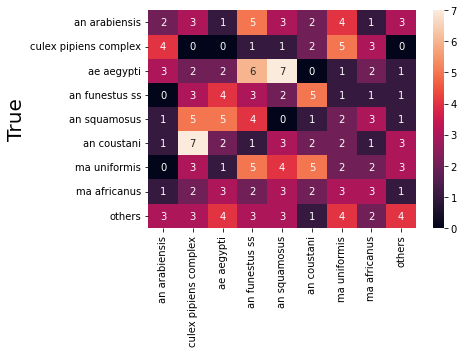

In [62]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [63]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

[array([0.49769671, 0.54904644, 0.60320839, 0.59262686, 0.54664781,
       0.22157672, 0.92114355, 0.3484423 , 0.91723578]), array([0.0870559 , 0.76448385, 0.13933122, 0.66527094, 0.37945161,
       0.87808389, 0.99234517, 0.99938301, 0.78951743]), array([0.36053041, 0.54445974, 0.73656632, 0.41868457, 0.54341021,
       0.79700344, 0.63400894, 0.08090071, 0.087007  ]), array([0.47534793, 0.08431298, 0.76122473, 0.25762097, 0.30764684,
       0.65892902, 0.93182514, 0.13027765, 0.92376008]), array([0.24393664, 0.37170802, 0.9979696 , 0.87149963, 0.48899293,
       0.64526428, 0.05580208, 0.0401177 , 0.48596449]), array([0.10771086, 0.13711956, 0.1353652 , 0.21101119, 0.52245524,
       0.83327093, 0.22746035, 0.47806891, 0.15463175]), array([0.32009553, 0.02780889, 0.58221359, 0.6358467 , 0.17342752,
       0.41339929, 0.62142743, 0.27960739, 0.94674956]), array([0.33052019, 0.13757801, 0.02274199, 0.35893381, 0.00728098,
       0.71627491, 0.75964388, 0.47418129, 0.5133967 ]), array([

ValueError: continuous-multioutput is not supported

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))